# Model training

In this file, I want to build and train some models and select the best predictor of ace/no ace.

## Importing libraries

In [3]:
# Import everything from my_libraries.py
from my_libraries import *  # noqa: F403

# Other utilities
import tennis_utils
import dataframe_utils

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [4]:
# Read into dataframe
df = pd.read_csv("datasets/task_set.csv")

# Clean dataframe
df = dataframe_utils.clean_dataframe(df)

In [5]:
# Split data while maintaining the proportion of 'is_ace'
X = df.drop("is_ace", axis=1)
y = df["is_ace"]

# Perform stratified split using train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Save the train dataset in a new csv file
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.to_csv("datasets/train_dataset.csv")

In [6]:
# Impute missing values and feature engineer
X_train, X_test = [dataframe_utils.impute_data(df) for df in (X_train, X_test)]
X_train, X_test = [dataframe_utils.feature_engineer(df) for df in (X_train, X_test)]

In [7]:
X_train

,bin_mean_ball_hit_y,ball_bounce_y,receiver_y,ball_hit_x,ball_net_z,ball_bounce_x,ball_bounce_angle,hitter_x,receiver_x,dist_ball_bounce_x_returner_x,dist_ball_bounce_y_returner_y,bin_mean_speed,bin_mean_ball_hit_z,surface_clay,surface_hard,hitter_hand_left,receiver_hand_left,serve_number,close_to_side_line,close_to_center_line,close_to_service_line
0,0.829585,-0.168997,-0.902120,0.178764,-1.483581,-0.687501,0.142768,1.134956,0.911763,1.183361,1.076071,0.112884,-0.353871,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.535732,0.279581,0.113482,1.810995,0.242343,0.912734,-0.835339,0.929693,0.973754,0.459598,0.690109,1.346496,0.600041,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.267366,-0.219920,-0.678570,1.642724,0.198089,1.024628,-0.645843,0.450747,1.398830,0.800148,-0.404254,0.994036,-0.353871,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.355822,0.842736,0.098187,0.100238,0.242343,0.345601,0.184168,0.318792,0.031017,-0.139920,-1.213970,0.465345,0.600041,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,-0.355822,0.014978,0.051347,0.952812,-0.819764,-1.361930,0.446028,-0.619551,1.287731,1.862216,1.176582,-0.415807,-0.353871,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115033,0.644178,-0.110334,-0.905124,-0.045597,-0.722404,0.391584,-1.138599,-0.775942,-0.093768,-0.278386,1.282722,1.515677,0.600041,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
115034,0.644178,-0.796805,-0.915776,0.330208,0.260045,0.396183,0.039774,-1.235339,-0.273299,-0.447538,-0.865800,-0.063346,0.600041,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
115035,-0.535732,0.145282,0.167423,1.766123,-0.625044,-0.098909,-0.439182,1.682323,0.951212,0.932626,1.440323,-0.415807,-1.297526,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
115036,0.829585,-0.314778,-0.909085,0.408735,-1.288861,-0.371746,-0.526693,0.949242,-0.607402,-0.383170,0.647493,0.994036,0.600041,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


## Imbalanced dataset

Almost 92% of serves are not aces. The data is highly imbalanced. For the machine learning model to learn effectively, the data has to be balanced. I am using the random oversampler for this. Note that there are not too many unique ways you can serve an ace. ie: high serve speed, aim at the lines, hit where your opponent doesn't expect you to but this will still be to the leftmost or rightmost of the ad/deuce court.

In [8]:
y_train.value_counts()

is_ace
0    105993
1      9045
Name: count, dtype: int64

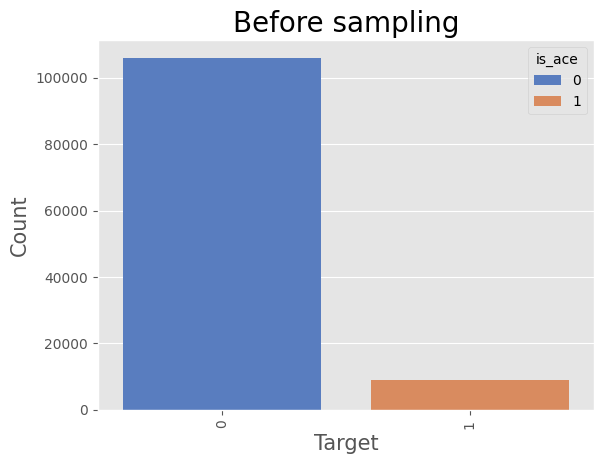

In [9]:
sns.countplot(data=pd.DataFrame(y_train), x="is_ace", hue="is_ace")
plt.xlabel("Target", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Count", fontsize=15)
plt.title("Before sampling", fontsize=20)
plt.show()

In [10]:
# # Random oversampling to make the majority and minority class even

# rd_over_sample = RandomOverSampler()
# X_train, y_train = rd_over_sample.fit_resample(X_train, y_train)

In [11]:
# BorderlineSMOTE1 sampling
smote = BorderlineSMOTE(kind="borderline-1", random_state=42)
# smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

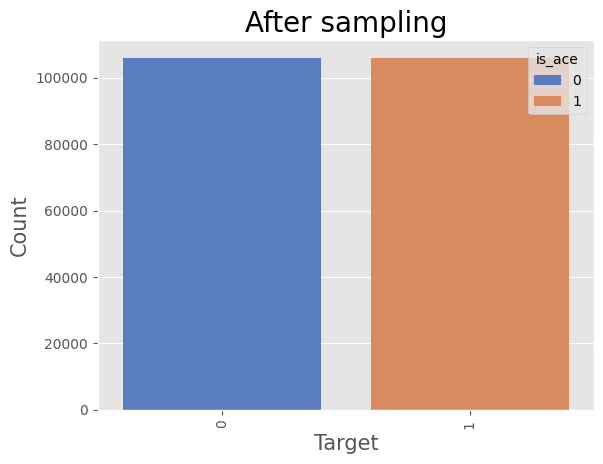

In [12]:
sns.countplot(data=pd.DataFrame(y_train), x="is_ace", hue="is_ace")
plt.xlabel("Target", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Count", fontsize=15)
plt.title("After sampling", fontsize=20)
plt.show()

# Models

In [13]:
def scoring():
    """A function to print scores and save them in lists."""
    print("\n-----Train Data Accuracy----")
    a_s = round(accuracy_score(y_train.to_numpy(), y_pred_train), 4)
    print("Accuracy score:", a_s)
    f_1 = round(f1_score(y_train.to_numpy(), y_pred_train), 4)
    print("F1 score:", f_1)
    accuracy_train.append(a_s)
    F1score_train.append(f_1)

    print("-----Test Data Accuracy----")
    a_s = round(accuracy_score(y_test.to_numpy(), y_pred), 4)
    print("Accuracy score:", a_s)
    f_1 = round(f1_score(y_test.to_numpy(), y_pred), 4)
    print("F1 score:", f_1)
    accuracy_test.append(a_s)
    F1score_test.append(f_1)

In [14]:
# Saving model scores in list for final evaluation
accuracy_test = []
accuracy_train = []
F1score_test = []
F1score_train = []

## Random Forest Classifer

In [15]:
# Got the best split from the GridSearchCV below
rfc = RandomForestClassifier(
    random_state=42, max_depth=4, n_estimators=50, min_samples_split=6
)

# Training Model
rfc.fit(X_train, y_train)
# Save model
joblib.dump(rfc, "rfc_model.joblib")
# Load model
saved_model = joblib.load("rfc_model.joblib")
# Predict
y_pred = saved_model.predict(X_test)
y_pred_train = saved_model.predict(X_train)

In [16]:
scoring()


-----Train Data Accuracy----
Accuracy score: 0.8708
F1 score: 0.8773
-----Test Data Accuracy----
Accuracy score: 0.8053
F1 score: 0.4115


### Using gridsearch cv for hyper parameter tuning

In [17]:
# param_grid = [
#     {
#         "n_estimators": [20, 50],
#         "max_depth": [5, 7, 10],
#         "min_samples_split": [2, 3, 6],
#     }
# ]

# grid_search = GridSearchCV(
#     estimator=RandomForestClassifier(),
#     param_grid=param_grid,
#     cv=2,
#     return_train_score=True,
#     verbose=True,
# )
# grid_search.fit(X_train, y_train)

# # Save the model so you don't have to run Gridsearchcv again.
# # Access the best model
# best_model = grid_search.best_estimator_
# best_parameters = grid_search.best_params_
# best_score = grid_search.best_score_

# # Save the best model to a file using joblib
# joblib.dump(best_model, "best_random_forest_model.joblib")

# # Grid_search.cv_results_ is a dictonary of each iteration of grid search, saving parameters and test and train scores.
# # Converting that to a df and saving as a csv so it can be accessed whenever.

# cv_results_df = pd.DataFrame(grid_search.cv_results_)
# cv_results_df.to_csv("cv_results.csv")

Obtaining the top ten most important features.

In [18]:
# # Extract feature importances
# importances = saved_model.feature_importances_

# # Create a DataFrame for feature importance
# feature_importance_df = pd.DataFrame(
#     {"Feature": X_train.columns, "Importance": importances}
# )

# # Sort features by importance
# top_features = feature_importance_df.sort_values(by="Importance", ascending=False).head(
#     10
# )

# # Display the top 10 features
# print("Top 10 Features for Serve Prediction:")
# print(top_features)

Three of new features engineered have made it into the top 10, two making it to top 3.

In [19]:
# # Visualize feature importance

# plt.figure(figsize=(10, 6))
# plt.barh(top_features["Feature"], top_features["Importance"], color="skyblue")
# plt.xlabel("Importance")
# plt.ylabel("Feature")
# plt.title("Top 10 Features for Serve Prediction")
# plt.gca().invert_yaxis()
# plt.show()

In [20]:
# # Sort features by importance
# worst_features = feature_importance_df.sort_values(
#     by="Importance", ascending=True
# ).head(10)

# # Display the top 10 features
# print("Worst 10 Features for Serve Prediction:")
# print(worst_features)

Dropping more columns

In [21]:
# new_columns_to_drop = ['receiver_hand_left', 'surface_hard', 'close_to_service_line','hitter_hand_left','serve_side_deuce','hitter_x']
# X_train.drop(columns=new_columns_to_drop, inplace=True)
# X_test.drop(columns=new_columns_to_drop, inplace=True)

### XG Boost

In [22]:
xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    reg_alpha=1,
    reg_lambda=1,
    colsample_bytree=0.85,
    subsample=0.85,
    learning_rate=0.02,
    n_estimators=50,
    max_depth=3,
    min_child_weight=20,
    gamma=10,
)

# Training Model
xgb.fit(X_train, y_train)

# Mode summary
y_pred = xgb.predict(X_test)
y_pred_train = xgb.predict(X_train)

scoring()


-----Train Data Accuracy----
Accuracy score: 0.8391
F1 score: 0.827
-----Test Data Accuracy----
Accuracy score: 0.8935
F1 score: 0.5124


In [23]:
joblib.dump(xgb, "xgb_model.joblib")

['xgb_model.joblib']

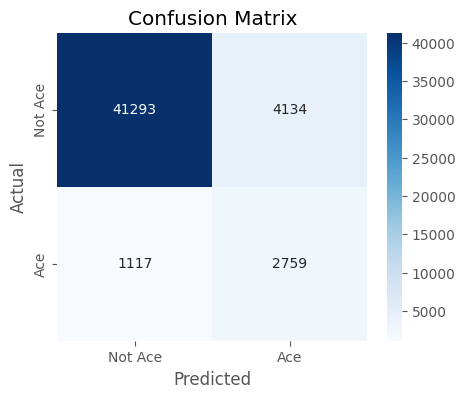

In [24]:
# Confusion Matrix Visualization
plt.figure(figsize=(5, 4))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Ace", "Ace"],
    yticklabels=["Not Ace", "Ace"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

More focus must be given to identifying why serves that are not aces are getting identified as aces.

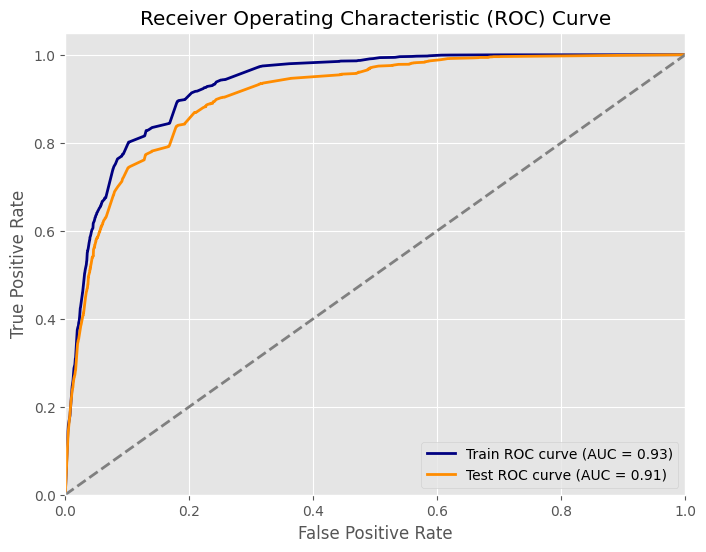

In [25]:
# Probability estimates for the positive class
y_prob_train = xgb.predict_proba(X_train)[:, 1]
y_prob_test = xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_prob_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_prob_test)

# Compute AUC
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(
    fpr_train,
    tpr_train,
    color="navy",
    lw=2,
    label=f"Train ROC curve (AUC = {roc_auc_train:.2f})",
)
plt.plot(
    fpr_test,
    tpr_test,
    color="darkorange",
    lw=2,
    label=f"Test ROC curve (AUC = {roc_auc_test:.2f})",
)
plt.plot(
    [0, 1], [0, 1], color="gray", lw=2, linestyle="--"
)  # Random classifier (diagonal)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


In [26]:
# Youden's index = TPR - FPR, which is maximized when the threshold gives the best trade-off.
youden_index = tpr_train - fpr_train
optimal_threshold = thresholds_train[
    np.argmax(youden_index)
]  # Find the threshold that maximizes Youden's index
# 7. Apply the optimal threshold to make final predictions
y_pred_optimal = (y_prob_test > optimal_threshold).astype(int)

# 8. Evaluate the model using confusion matrix and other metrics
conf_matrix = confusion_matrix(y_test, y_pred_optimal)
accuracy = accuracy_score(y_test, y_pred_optimal)
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)

# Print the evaluation metrics
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Optimal Threshold: 0.4732034504413605
Confusion Matrix:
[[37278  8149]
 [  629  3247]]
Accuracy: 0.82
Precision: 0.28
Recall: 0.84
F1-Score: 0.43


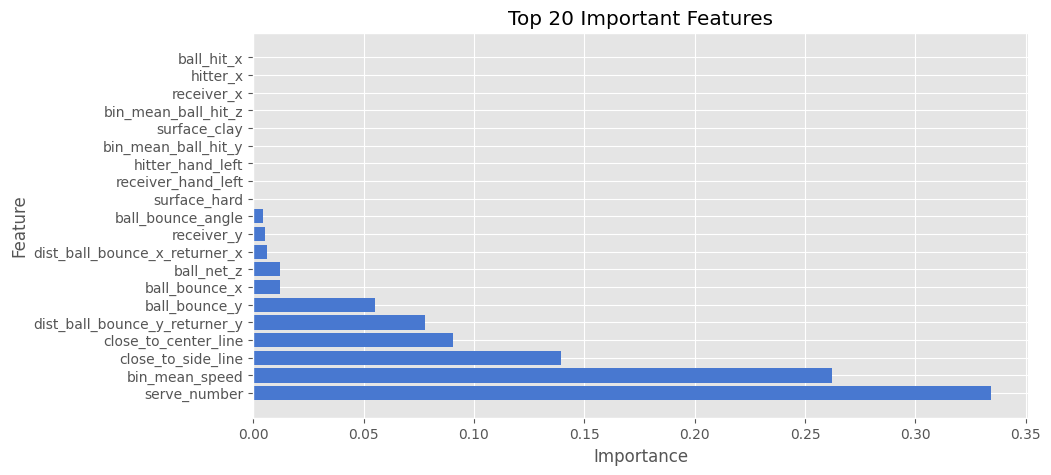

In [27]:
feature_importance = xgb.feature_importances_
feature_names = X_train.columns

# Sort and plot feature importance
feat_importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importance}
)
feat_importance_df = feat_importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
plt.barh(feat_importance_df["Feature"][:20], feat_importance_df["Importance"][:20])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 20 Important Features")
plt.show()

In [28]:
feat_importance_df

,Feature,Importance
17,serve_number,0.334397
11,bin_mean_speed,0.262286
18,close_to_side_line,0.139249
19,close_to_center_line,0.090317
10,dist_ball_bounce_y_returner_y,0.077641
1,ball_bounce_y,0.055382
5,ball_bounce_x,0.012292
4,ball_net_z,0.011985
9,dist_ball_bounce_x_returner_x,0.006401
2,receiver_y,0.005387


In [29]:
# Define a threshold (e.g., remove features with importance < 0.001)
threshold = 0.001

# Select only important features
selected_features = feat_importance_df[feat_importance_df["Importance"] > threshold][
    "Feature"
].tolist()

# Keep only selected features in training and test sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]


In [30]:
# Train XGBoost with selected features
model_selected = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    reg_alpha=1,
    reg_lambda=1,
    colsample_bytree=0.85,
    subsample=0.85,
    learning_rate=0.02,
    n_estimators=50,
    max_depth=4,
    min_child_weight=20,
    gamma=10,
)
model_selected.fit(X_train_selected, y_train)

# Evaluate the model
accuracy = model_selected.score(X_test_selected, y_test)
print(f"Accuracy after feature selection: {accuracy:.4f}")

# Mode summary
y_pred = model_selected.predict(X_test_selected)
y_pred_train = model_selected.predict(X_train_selected)

scoring()
# Calculate Precision and Recall for Training Data
train_precision = precision_score(y_train, y_pred_train)
train_recall = recall_score(y_train, y_pred_train)
# Calculate Precision and Recall for Test Data
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)

# Print results
print("----Precision and Recall----")
print(f"Training Precision: {train_precision:.4f}, Training Recall: {train_recall:.4f}")
print(f"Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")


Accuracy after feature selection: 0.8797

-----Train Data Accuracy----
Accuracy score: 0.8691
F1 score: 0.8665
-----Test Data Accuracy----
Accuracy score: 0.8797
F1 score: 0.5038
----Precision and Recall----
Training Precision: 0.8844, Training Recall: 0.8492
Test Precision: 0.3728, Test Recall: 0.7768


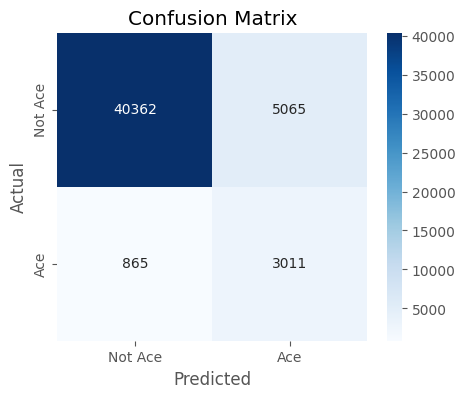

In [31]:
# Confusion Matrix Visualization
plt.figure(figsize=(5, 4))
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Not Ace", "Ace"],
    yticklabels=["Not Ace", "Ace"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [36]:
from sklearn.neighbors import NearestNeighbors

# Load your tennis dataset (replace 'tennis_data.csv' with your file)
df = pd.read_csv("datasets/task_set.csv")
# Impute missing values and feature engineer
df = dataframe_utils.impute_data(df)
df = dataframe_utils.feature_engineer(df)
df

,bin_mean_ball_hit_y,ball_bounce_y,receiver_y,ball_hit_x,ball_net_z,ball_bounce_x,ball_bounce_angle,hitter_x,receiver_x,dist_ball_bounce_x_returner_x,dist_ball_bounce_y_returner_y,bin_mean_speed,bin_mean_ball_hit_z,surface_clay,surface_hard,hitter_hand_left,receiver_hand_left,serve_number,close_to_side_line,close_to_center_line,close_to_service_line
0,0.824088,-0.610334,-0.902120,128.036850,0.622932,-14.508686,1.543622,114.571876,-22.064915,-0.029896,-0.345556,-1.296958,-0.353871,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0
1,0.634183,-0.195956,-0.969991,0.863067,-1.341967,-0.836182,-0.741096,-0.194364,1.122691,1.452058,1.388861,1.170266,-0.353871,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.451774,-0.976286,-0.898570,126.376574,-0.129394,-16.020019,-0.637092,113.589547,-22.335418,-0.516397,-1.223619,-0.063346,-0.353871,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.549725,0.420869,0.049981,128.278039,-0.669299,-13.777544,1.047837,114.332402,-20.482953,-1.143608,-0.138905,-0.944498,-1.297526,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,0.451774,-0.172741,-0.910177,2.226064,-0.678150,0.296551,-0.880778,0.959016,0.208133,0.048692,1.111451,0.817805,-1.297526,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187921,0.269365,-0.817524,-0.912362,126.830906,0.525572,-15.319533,0.439297,113.760599,-23.622724,1.022441,-0.952642,-1.296958,-1.297526,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0
187922,0.634183,-0.818772,-0.865112,0.133892,-0.775509,-0.670640,-0.508181,0.436085,-0.680664,-0.305330,-1.234877,0.112884,-0.353871,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
187923,0.824088,-0.929356,-0.937353,0.717232,-0.271009,-0.880633,0.676250,0.387213,0.326478,0.733535,-1.165725,-0.415807,-0.353871,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
187924,0.451774,-0.433100,-0.874535,126.544845,0.286598,-17.445516,-1.416953,113.970749,-22.648590,-0.921315,0.062921,1.515677,-0.353871,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
# Keep only selected featrues from feature importances
selected_features.append("is_ace")
df = df[selected_features]
# Define the target column (Assuming "ace" is 1 for aces, 0 for non-aces)
target_column = "is_ace"


KeyError: "['is_ace'] not in index"

In [ ]:
# Separate aces and non-aces
aces = df[df[target_column] == 1].drop(columns=[target_column])  # Features of aces
non_aces = df[df[target_column] == 0].drop(
    columns=[target_column]
)  # Features of non-aces


In [35]:
selected_features

['serve_number',
 'bin_mean_speed',
 'close_to_side_line',
 'close_to_center_line',
 'dist_ball_bounce_y_returner_y',
 'ball_bounce_y',
 'ball_bounce_x',
 'ball_net_z',
 'dist_ball_bounce_x_returner_x',
 'receiver_y',
 'ball_bounce_angle',
 'is_ace']

In [ ]:
# Fit Nearest Neighbors on non-aces
nn = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn.fit(non_aces)

# Find nearest non-ace for each ace
distances, indices = nn.kneighbors(aces)

# Create a DataFrame for differences
diff_data = []

for i, idx in enumerate(indices.flatten()):
    ace_features = aces.iloc[i]
    non_ace_features = non_aces.iloc[idx]

    # Compute feature-wise difference
    diff = ace_features - non_ace_features
    diff_data.append(diff)

# Convert to DataFrame
diff_df = pd.DataFrame(diff_data)

# Save as a CSV database
diff_df.to_csv("ace_nonace_differences.csv", index=False)

print("Database created successfully!")


In [ ]:
df

,serve_number,bin_mean_speed,close_to_side_line,close_to_center_line,dist_ball_bounce_y_returner_y,ball_bounce_y,ball_bounce_x,ball_net_z,dist_ball_bounce_x_returner_x,receiver_y,ball_bounce_angle
0,1.0,0.112884,0.0,0.0,1.076071,-0.168997,-0.687501,-1.483581,1.183361,-0.902120,0.142768
1,1.0,1.346496,0.0,0.0,0.690109,0.279581,0.912734,0.242343,0.459598,0.113482,-0.835339
2,1.0,0.994036,0.0,0.0,-0.404254,-0.219920,1.024628,0.198089,0.800148,-0.678570,-0.645843
3,1.0,0.465345,0.0,0.0,-1.213970,0.842736,0.345601,0.242343,-0.139920,0.098187,0.184168
4,2.0,-0.415807,0.0,1.0,1.176582,0.014978,-1.361930,-0.819764,1.862216,0.051347,0.446028
...,...,...,...,...,...,...,...,...,...,...,...
115033,1.0,1.515677,0.0,0.0,1.282722,-0.110334,0.391584,-0.722404,-0.278386,-0.905124,-1.138599
115034,1.0,-0.063346,0.0,0.0,-0.865800,-0.796805,0.396183,0.260045,-0.447538,-0.915776,0.039774
115035,2.0,-0.415807,0.0,0.0,1.440323,0.145282,-0.098909,-0.625044,0.932626,0.167423,-0.439182
115036,1.0,0.994036,0.0,0.0,0.647493,-0.314778,-0.371746,-1.288861,-0.383170,-0.909085,-0.526693
